In [38]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
from mnist import label_to_name
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
import numpy as np
import os
%aimport viz
%aimport training
%aimport evaluation
%aimport lenet
from lenet import lenet_5
from viz import display_label_distribution, display_images, display_confusion_matrix
from training import test_train_split, train
from evaluation import compute_metrics
from collections import defaultdict
from keras.models import Model


In [10]:
# load v1 data
images_v1 = np.load("../data/v1/images.npy")
labels_v1 = np.load("../data/v1/labels.npy")

In [11]:
images_v1.shape

(55200, 784)

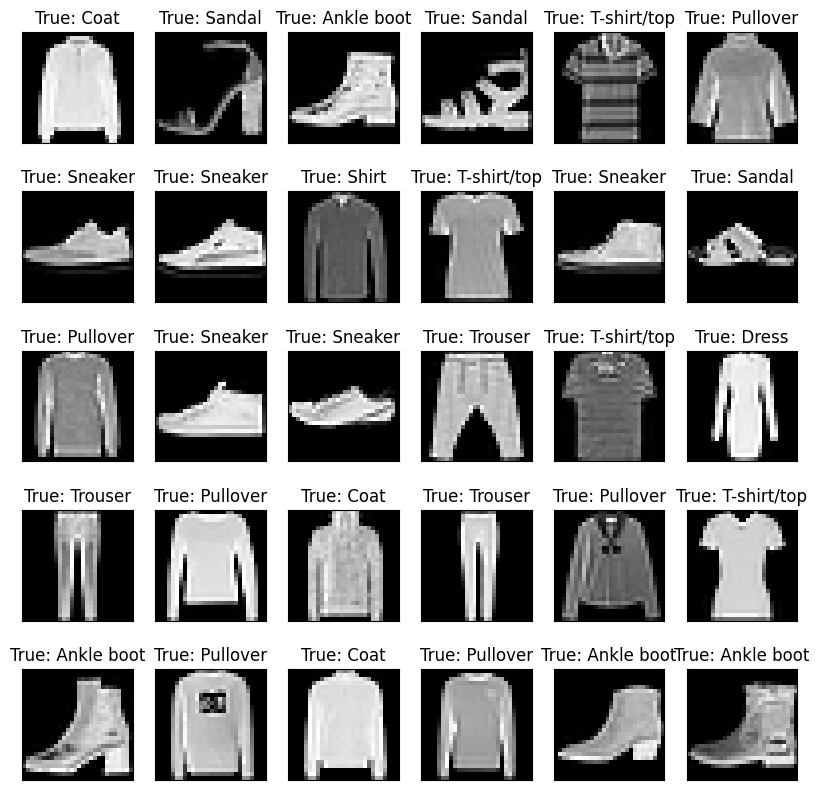

In [12]:
display_images(images_v1, labels_v1, random=True)

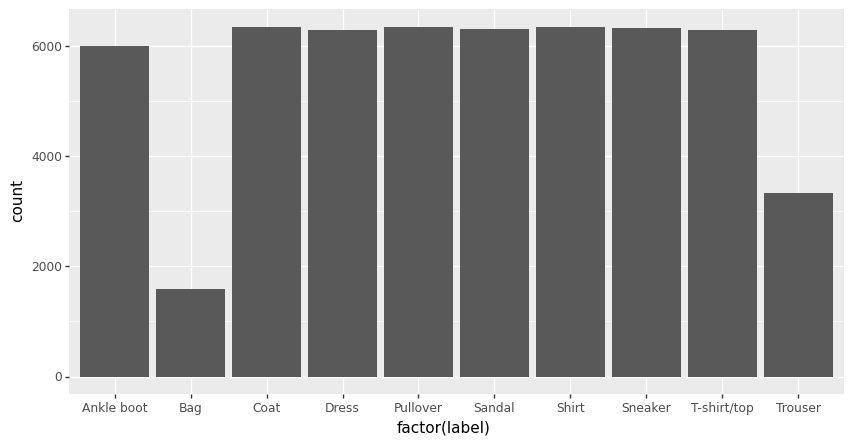

In [42]:
print(display_label_distribution(labels_v1))

In [43]:
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = test_train_split(images_v1, labels_v1)

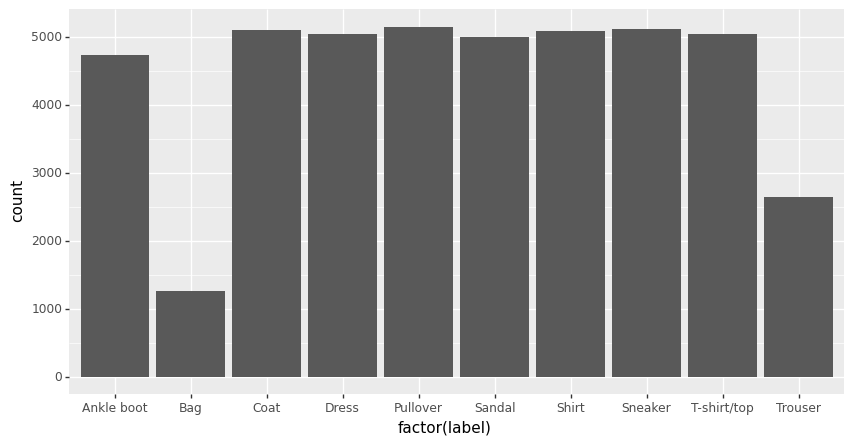

In [44]:
print(display_label_distribution(y_train_v1))


In [47]:
# train a dummy classifier on train data
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent')
clf.fit(X_train_v1, y_train_v1)
print(compute_metrics(y_test_v1, clf.predict(X_test_v1)))

# train a random classifier on train data
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='uniform')
clf.fit(X_train_v1, y_train_v1)
print(compute_metrics(y_test_v1, clf.predict(X_test_v1)))

# train a random forest classifier on train data
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train_v1, y_train_v1)
print(compute_metrics(y_test_v1, clf.predict(X_test_v1)))


{'accuracy': 0.109, 'f1': 0.02}
{'accuracy': 0.1, 'f1': 0.098}
{'accuracy': 0.829, 'f1': 0.821}


In [50]:
model_v1 = lenet_5()
display(model_v1.summary())
model_v1 = train(model_v1, X_train_v1, y_train_v1, X_test_v1, y_test_v1, output_dir='models/v1', epochs=30)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-13 13:12:24.931102: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-13 13:12:24.931517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

None

Epoch 1/30


2023-03-13 13:12:25.310810: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-13 13:12:25.806985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


687/690 [============================>.] - ETA: 0s - loss: 1.1824 - accuracy: 0.6846

2023-03-13 13:12:34.927165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.72201, saving model to models/v1/best.h5
690/690 [==============================] - 11s 15ms/step - loss: 1.1811 - accuracy: 0.6847 - val_loss: 0.7220 - val_accuracy: 0.7571
Epoch 2/30
689/690 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.7717
Epoch 2: val_loss improved from 0.72201 to 0.64711, saving model to models/v1/best.h5
690/690 [==============================] - 10s 14ms/step - loss: 0.6680 - accuracy: 0.7716 - val_loss: 0.6471 - val_accuracy: 0.7815
Epoch 3/30
688/690 [============================>.] - ETA: 0s - loss: 0.5987 - accuracy: 0.7965
Epoch 3: val_loss improved from 0.64711 to 0.62865, saving model to models/v1/best.h5
690/690 [==============================] - 10s 14ms/step - loss: 0.5986 - accuracy: 0.7965 - val_loss: 0.6286 - val_accuracy: 0.7889
Epoch 4/30
687/690 [============================>.] - ETA: 0s - loss: 0.5612 - accuracy: 0.8084
Epoch 4: val_loss improved from 0.62865 to 0.59377, saving

In [51]:
model_v1.load_weights('models/v1/best.h5')

In [52]:
# metrics on test set
y_pred_test_v1 = model_v1.predict(X_test_v1.reshape(-1, 28, 28, 1)).argmax(axis=1, keepdims=False)

 32/345 [=>............................] - ETA: 1s

2023-03-13 13:16:16.534158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 1s 3ms/step


In [56]:
data = defaultdict(list)
for i in range(10):
   data["label"].append(label_to_name(i))
   idx = np.argwhere(y_pred_test_v1 == i).flatten()
   metrics = compute_metrics(y_test_v1[idx], y_pred_test_v1[idx])
   for k, v in metrics.items():
       data[k].append(v)
pd.DataFrame(data).sort_values(by="accuracy")
    

,label,accuracy,f1
1,Trouser,0.545,0.078
6,Shirt,0.684,0.102
4,Coat,0.777,0.125
0,T-shirt/top,0.827,0.113
2,Pullover,0.855,0.154
3,Dress,0.872,0.103
8,Bag,0.934,0.193
7,Sneaker,0.951,0.195
9,Ankle boot,0.956,0.326
5,Sandal,0.968,0.123


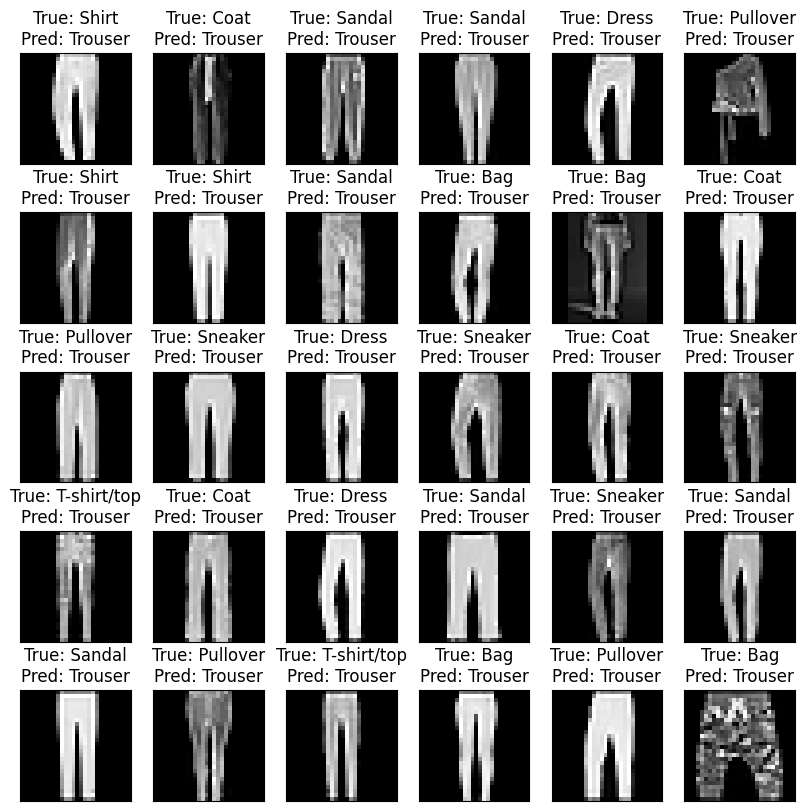

In [64]:
indices = np.argwhere((y_test_v1 != 1) & (y_pred_test_v1 == 1)).flatten()
trouser_images = X_test_v1[indices]
trouser_labels = y_test_v1[indices]
trouser_preds = y_pred_test_v1[indices]

display_images(trouser_images, trouser_labels, trouser_preds, random=True)

In [66]:
# load v2 data
images_v2 = np.load("../data/v2/images.npy")
labels_v2 = np.load("../data/v2/labels.npy")
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = test_train_split(images_v2, labels_v2)

In [94]:
model_v2 = lenet_5()
model_v2 = train(model_v2, X_train_v2, y_train_v2, X_test_v2, y_test_v2, output_dir='models/v2', epochs=30)


Epoch 1/30
  1/690 [..............................] - ETA: 5:22 - loss: 54.8844 - accuracy: 0.1719

2023-03-13 13:47:13.808845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


690/690 [==============================] - ETA: 0s - loss: 0.9881 - accuracy: 0.7410

2023-03-13 13:47:24.476334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.54841, saving model to models/v2/best.h5
690/690 [==============================] - 13s 18ms/step - loss: 0.9881 - accuracy: 0.7410 - val_loss: 0.5484 - val_accuracy: 0.7960
Epoch 2/30
689/690 [============================>.] - ETA: 0s - loss: 0.4808 - accuracy: 0.8211
Epoch 2: val_loss improved from 0.54841 to 0.45288, saving model to models/v2/best.h5
690/690 [==============================] - 12s 18ms/step - loss: 0.4807 - accuracy: 0.8211 - val_loss: 0.4529 - val_accuracy: 0.8394
Epoch 3/30
688/690 [============================>.] - ETA: 0s - loss: 0.4182 - accuracy: 0.8433
Epoch 3: val_loss improved from 0.45288 to 0.43164, saving model to models/v2/best.h5
690/690 [==============================] - 12s 17ms/step - loss: 0.4181 - accuracy: 0.8432 - val_loss: 0.4316 - val_accuracy: 0.8393
Epoch 4/30
689/690 [============================>.] - ETA: 0s - loss: 0.3786 - accuracy: 0.8565
Epoch 4: val_loss improved from 0.43164 to 0.41849, saving

In [95]:
y_pred_test_v2 = model_v2.predict(X_test_v2.reshape(-1, 28, 28, 1)).argmax(axis=1, keepdims=False)

 41/345 [==>...........................] - ETA: 1s

2023-03-13 13:49:28.279550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 1s 4ms/step


In [96]:
compute_metrics(y_test_v2, y_pred_test_v2)

{'accuracy': 0.869, 'f1': 0.868}

In [69]:
data = defaultdict(list)
for i in range(10):
   data["label"].append(label_to_name(i))
   idx = np.argwhere(y_pred_test_v2 == i).flatten()
   metrics = compute_metrics(y_test_v2[idx], y_pred_test_v2[idx])
   for k, v in metrics.items():
       data[k].append(v)
pd.DataFrame(data).sort_values(by="accuracy")
    

,label,accuracy,f1
6,Shirt,0.711,0.104
4,Coat,0.814,0.128
2,Pullover,0.834,0.152
0,T-shirt/top,0.849,0.115
3,Dress,0.863,0.103
8,Bag,0.920,0.160
9,Ankle boot,0.943,0.243
7,Sneaker,0.964,0.245
5,Sandal,0.980,0.141
1,Trouser,0.994,0.166


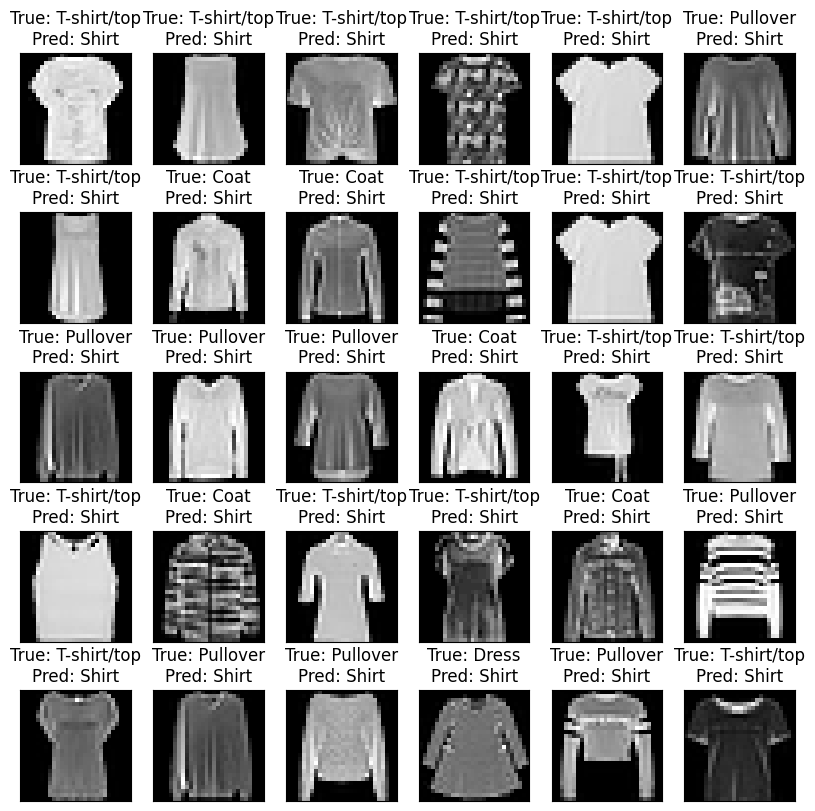

In [73]:
false_shirts = np.argwhere((y_test_v2 != 6) & (y_pred_test_v2 == 6)).flatten()
shirt_images = X_test_v2[false_shirts]
shirt_labels = y_test_v2[false_shirts]
shirt_preds = y_pred_test_v2[false_shirts]
display_images(shirt_images, shirt_labels, shirt_preds, random=True)

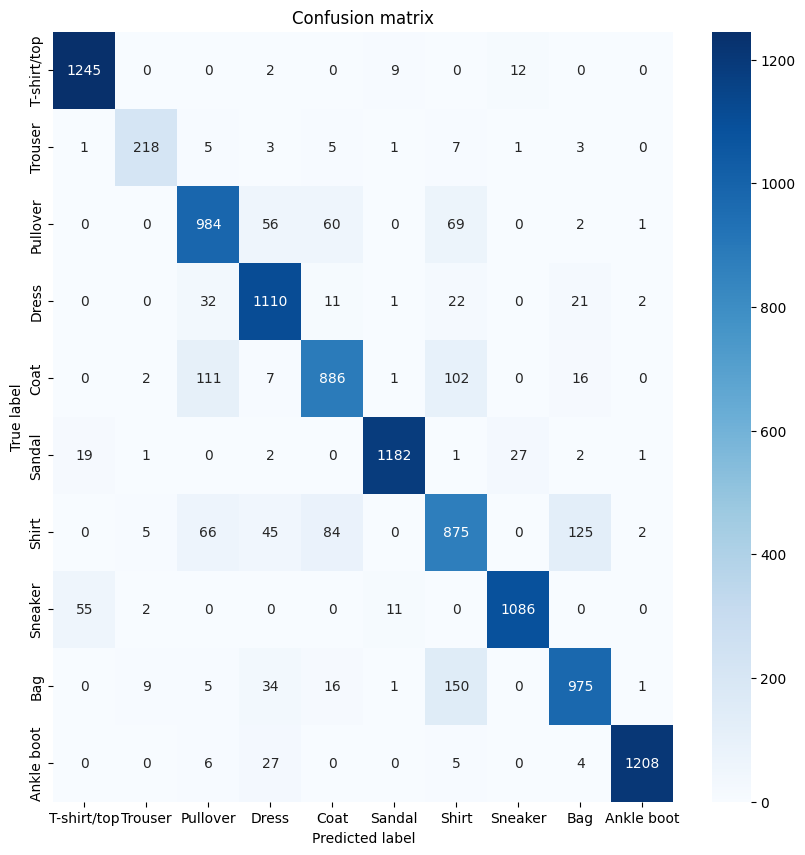

In [86]:
display_confusion_matrix(y_test_v2, y_pred_test_v2)

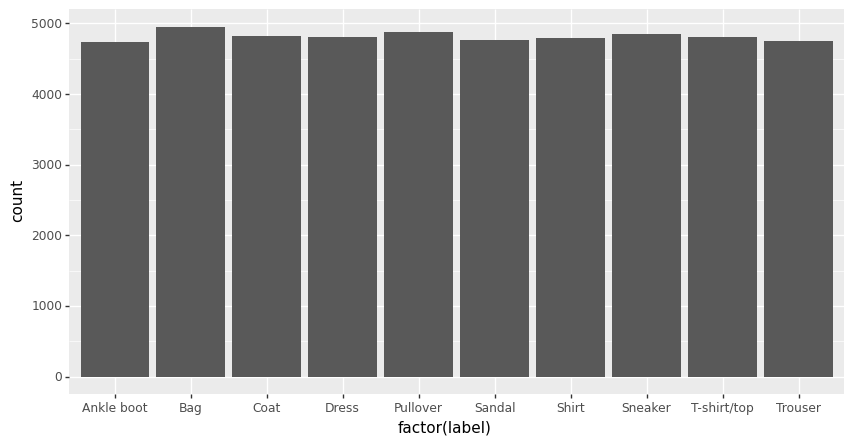

<ggplot: (788090299)>

In [89]:
# oversample bag in the v2 dataset


bag_indices = np.argwhere(y_train_v2 == 8).flatten()

new_indices = np.random.choice(bag_indices, 4000, replace=True)
X_train_v3 = np.concatenate([X_train_v2, X_train_v2[new_indices]])
y_train_v3 = np.concatenate([y_train_v2, y_train_v2[new_indices]])
display_label_distribution(y_train_v3)

In [97]:
model_v3 = lenet_5()
model_v3 = train(model_v3, X_train_v3, y_train_v3, X_test_v2, y_test_v2, output_dir='models/v3', epochs=30)

Epoch 1/30
  1/753 [..............................] - ETA: 5:38 - loss: 105.2020 - accuracy: 0.1094

2023-03-13 13:49:30.059566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


753/753 [==============================] - ETA: 0s - loss: 1.1549 - accuracy: 0.7404

2023-03-13 13:49:42.785293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.56817, saving model to models/v3/best.h5
753/753 [==============================] - 15s 20ms/step - loss: 1.1549 - accuracy: 0.7404 - val_loss: 0.5682 - val_accuracy: 0.7945
Epoch 2/30
751/753 [============================>.] - ETA: 0s - loss: 0.4633 - accuracy: 0.8328
Epoch 2: val_loss improved from 0.56817 to 0.45899, saving model to models/v3/best.h5
753/753 [==============================] - 14s 19ms/step - loss: 0.4634 - accuracy: 0.8328 - val_loss: 0.4590 - val_accuracy: 0.8347
Epoch 3/30
752/753 [============================>.] - ETA: 0s - loss: 0.3929 - accuracy: 0.8552
Epoch 3: val_loss improved from 0.45899 to 0.40543, saving model to models/v3/best.h5
753/753 [==============================] - 15s 20ms/step - loss: 0.3929 - accuracy: 0.8551 - val_loss: 0.4054 - val_accuracy: 0.8520
Epoch 4/30
753/753 [==============================] - ETA: 0s - loss: 0.3572 - accuracy: 0.8663
Epoch 4: val_loss improved from 0.40543 to 0.39151, saving

In [98]:
y_pred_test_v3 = model_v3.predict(X_test_v2.reshape(-1, 28, 28, 1)).argmax(axis=1, keepdims=False)
compute_metrics(y_test_v2, y_pred_test_v3)

 24/345 [=>............................] - ETA: 1s

2023-03-13 13:53:08.160837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 2s 5ms/step


{'accuracy': 0.88, 'f1': 0.881}

In [99]:
data = defaultdict(list)
for i in range(10):
   data["label"].append(label_to_name(i))
   idx = np.argwhere(y_pred_test_v3 == i).flatten()
   metrics = compute_metrics(y_test_v2[idx], y_pred_test_v3[idx])
   for k, v in metrics.items():
       data[k].append(v)
pd.DataFrame(data).sort_values(by="accuracy")
    

,label,accuracy,f1
6,Shirt,0.699,0.118
4,Coat,0.789,0.126
2,Pullover,0.844,0.153
0,T-shirt/top,0.859,0.132
8,Bag,0.862,0.116
3,Dress,0.880,0.134
7,Sneaker,0.926,0.321
9,Ankle boot,0.960,0.327
5,Sandal,0.978,0.198
1,Trouser,0.982,0.198


In [100]:
model_v4 = train(lenet_5(dropout_rate=0.5), X_train_v3, y_train_v3, X_test_v2, y_test_v2, output_dir='models/v4', epochs=30)

Epoch 1/30


2023-03-13 13:57:51.408117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


753/753 [==============================] - ETA: 0s - loss: 2.4603 - accuracy: 0.4308

2023-03-13 13:58:05.542569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.97543, saving model to models/v4/best.h5
753/753 [==============================] - 17s 21ms/step - loss: 2.4603 - accuracy: 0.4308 - val_loss: 0.9754 - val_accuracy: 0.6945
Epoch 2/30
752/753 [============================>.] - ETA: 0s - loss: 0.9294 - accuracy: 0.6646
Epoch 2: val_loss improved from 0.97543 to 0.77472, saving model to models/v4/best.h5
753/753 [==============================] - 16s 21ms/step - loss: 0.9292 - accuracy: 0.6646 - val_loss: 0.7747 - val_accuracy: 0.7326
Epoch 3/30
753/753 [==============================] - ETA: 0s - loss: 0.7693 - accuracy: 0.7200
Epoch 3: val_loss improved from 0.77472 to 0.64579, saving model to models/v4/best.h5
753/753 [==============================] - 16s 21ms/step - loss: 0.7693 - accuracy: 0.7200 - val_loss: 0.6458 - val_accuracy: 0.7699
Epoch 4/30
752/753 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.7472
Epoch 4: val_loss improved from 0.64579 to 0.61167, saving

In [101]:
model_v5 = train(lenet_5(dropout_rate=0.2), X_train_v3, y_train_v3, X_test_v2, y_test_v2, output_dir='models/v5', epochs=30)

Epoch 1/30


2023-03-13 14:05:22.323200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


753/753 [==============================] - ETA: 0s - loss: 1.3844 - accuracy: 0.6334

2023-03-13 14:05:37.003175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.63481, saving model to models/v5/best.h5
753/753 [==============================] - 17s 22ms/step - loss: 1.3844 - accuracy: 0.6334 - val_loss: 0.6348 - val_accuracy: 0.7533
Epoch 2/30
753/753 [==============================] - ETA: 0s - loss: 0.6365 - accuracy: 0.7629
Epoch 2: val_loss improved from 0.63481 to 0.52134, saving model to models/v5/best.h5
753/753 [==============================] - 16s 22ms/step - loss: 0.6365 - accuracy: 0.7629 - val_loss: 0.5213 - val_accuracy: 0.8085
Epoch 3/30
751/753 [============================>.] - ETA: 0s - loss: 0.5436 - accuracy: 0.7992
Epoch 3: val_loss improved from 0.52134 to 0.49413, saving model to models/v5/best.h5
753/753 [==============================] - 15s 20ms/step - loss: 0.5438 - accuracy: 0.7992 - val_loss: 0.4941 - val_accuracy: 0.8185
Epoch 4/30
753/753 [==============================] - ETA: 0s - loss: 0.4867 - accuracy: 0.8187
Epoch 4: val_loss improved from 0.49413 to 0.43133, saving

In [102]:
y_pred_test_v5 = model_v5.predict(X_test_v2.reshape(-1, 28, 28, 1)).argmax(axis=1, keepdims=False)
compute_metrics(y_test_v2, y_pred_test_v5)

 14/345 [>.............................] - ETA: 2s

2023-03-13 14:12:54.887176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 2s 4ms/step


{'accuracy': 0.888, 'f1': 0.891}

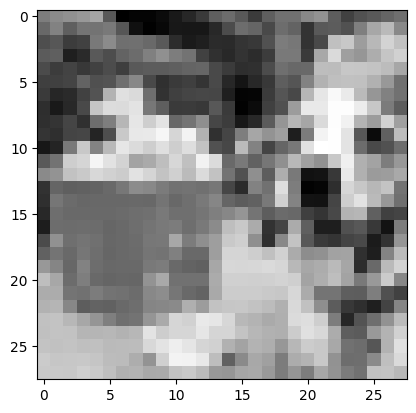

In [107]:
# load png image from assets/dog_popcorn.png
from PIL import Image
import requests
from io import BytesIO

image_path = "../assets/dog_popcorn.png"
#load image from image path
img = Image.open(image_path)
#resize image to 28x28
img = img.resize((28,28))
#convert image to grayscale
img = img.convert('L')
# convert image to numpy array
img = np.array(img)
# display image
plt.imshow(img, cmap='gray')



In [262]:
X_test_v2.shape

(11040, 784)

In [263]:
pred = model_v5.predict(X_test_v2.reshape(-1, 28, 28, 1))

345/345 [==============================] - 1s 4ms/step


{'accuracy': 0.961, 'f1': 0.953}

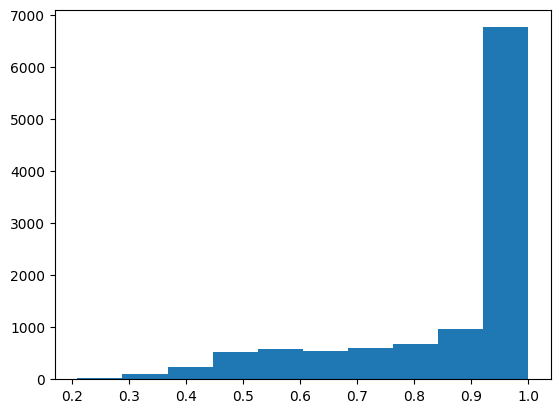

In [273]:
plt.hist(pred.max(axis=1))

low_confidence_indices = np.argwhere(pred.max(axis=1) > 0.7).flatten()

compute_metrics(y_test_v2[low_confidence_indices], pred[low_confidence_indices].argmax(axis=1))

In [205]:
pred = model_v5.predict(img.reshape(-1, 28, 28, 1)).argmax(axis=1, keepdims=False)
label_to_name(pred[])

1/1 [==============================] - 0s 110ms/step


'Shirt'

In [227]:
model_v5(img.reshape(-1, 28, 28, 1), training=True).numpy().max()

0.67398137

In [212]:
model_v5(X_test_v2[0].reshape(-1, 28, 28, 1)).numpy().max()

1.0

In [ ]:
# outlier detection
from sklearn.mixture import GaussianMixture

# create a gaussian mixture model with 10 components
gmm = GaussianMixture(n_components=10)
# fit the gmm to the training data
indices = np.random.choice(len(X_train_v3), len(X_train_v3)//4)
X_train_v3_subset = X_train_v3[indices]
gmm.fit(X_train_v3_subset)
boundary = np.quantile(gmm.score_samples(X_train_v3), 0.01)
gmm.score_samples(img.reshape(1, -1)) < boundary

array([ True])